# Notebook to do Data Augmentation of positive instances of Fire Damage in Satellite images
## Augmentation of damage pairs using fire polygons masks
### Import necessary packages

In [25]:
import os
import tifffile
import shutil
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import re

### Let's define the function to find the files that have damage

In [13]:
def check_tiff_file(tiff_file_path):
    # Read the TIFF file
    tiff_data = tifffile.imread(tiff_file_path)

    # Check if the array contains at least one pixel with a value of 1 
    return 1 in tiff_data

def find_tiff_files_with_ones(directory_path):
    # Get a list of all TIFF files in the specified directory
    tiff_files = [file for file in os.listdir(directory_path) if file.lower().endswith('.tif') or file.lower().endswith('.tiff')]

    # Initialize counters and a list for names
    total_tiles = 0
    tiles_with_ones = 0
    names_with_ones = []

    # Check each file
    for file in tiff_files:
        file_path = os.path.join(directory_path, file)
        if check_tiff_file(file_path):
            tiles_with_ones += 1
            names_with_ones.append(file)
        total_tiles += 1

    return total_tiles, tiles_with_ones, names_with_ones

# Specify the directory containing your TIFF files
directory_path = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterMaskSegments'

# Find total number of tiles, tiles with at least one pixel value of 1, and names of tiles with ones
total_tiles, tiles_with_ones, names_with_ones = find_tiff_files_with_ones(directory_path)

# Print the result
print(f"Total number of tiles: {total_tiles}")
print(f"Number of tiles with at least one pixel value of 1: {tiles_with_ones}")

Total number of tiles: 82082
Number of tiles with at least one pixel value of 1: 4847


### Define the function to make a copy of the files with damage to a new location to perform and test augmentation methods

In [17]:
def copy_files_to_destination(source_directory, destination_directory, file_names):
    for file_name in file_names:
        source_path = os.path.join(source_directory, file_name)
        destination_path = os.path.join(destination_directory, file_name)
        shutil.copy(source_path, destination_path)

In [18]:
# Specify the destination directory for copying files
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/DamageTiles'

# Copy files with ones to the destination directory
copy_files_to_destination(directory_path, destination_directory, names_with_ones)

In [24]:
def move_rgb_files(source_directory, destination_directory, names_with_ones):
    for file_name in names_with_ones:
        # Extract X and Y values from the file name
        parts = file_name.split('_')

        # Ensure that there are enough parts to extract X and Y values
        if len(parts) >= 6:
            # Find the part containing the X value (it should contain a numeric character)
            x_value_part = next((part for part in parts if any(char.isdigit() for char in part)), None)

            if x_value_part:
                x_value = x_value_part.replace("AfterFire", "")
                y_value = parts[-1].replace(".tif", "")

                # Form the corresponding file name from the second directory
                corresponding_file_name = f"RGB_AfterFire{str(x_value)}_tile_{str(y_value)}.tif"
                source_path = os.path.join(source_directory, corresponding_file_name)

                # Check if the corresponding file exists
                if os.path.exists(source_path):
                    # Move the file to the destination directory
                    destination_path = os.path.join(destination_directory, corresponding_file_name)
                    print(f"Moving from {source_path} to {destination_path}")
                    shutil.move(source_path, destination_path)
                else:
                    print(f"File not found: {source_path}")
            else:
                print(f"Invalid file name format: {file_name}")
        else:
            print(f"Invalid file name format: {file_name}")

# Specify the directories
directory_path_1 = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterMaskSegments'
directory_path_2 = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterRGBSegments'
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles'

# Move RGB files to the destination directory
move_rgb_files(directory_path_2, destination_directory, names_with_ones)


Moving from /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterRGBSegments/RGB_AfterFire713_tile_105.tif to /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles/RGB_AfterFire713_tile_105.tif
Moving from /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterRGBSegments/RGB_AfterFire712_tile_25.tif to /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles/RGB_AfterFire712_tile_25.tif
Moving from /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterRGBSegments/RGB_AfterFire712_tile_26.tif to /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles/RGB_AfterFire712_tile_26.tif
Moving from /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterRGBSegments/RGB_AfterFire712_tile_42.tif to /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles/RGB_AfterFire712_tile_42.tif
Moving from /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/AfterRGBSegments/RGB_AfterFire712_tile_43.tif to /Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles/RGB_Aft

### Define rotation function

In [4]:
def rotate_image(image_path, output_path, n): #n defines the amount of the rotation
    with rasterio.open(image_path) as src:
        # Read the image data and metadata
        img_array = src.read()
        metadata = src.meta

        # Rotate the image array by 90 degrees to the right
        rotated_img_array = np.rot90(img_array, k=n, axes=(1, 2))  # Rotate along the height and width axes

        # Update metadata with the rotated transform
        new_transform = from_origin(metadata['transform'][2], metadata['transform'][5], metadata['transform'][0], metadata['transform'][4])

        metadata.update(transform=new_transform)

        # Save the rotated image
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(rotated_img_array)

### Augment the data with a 90 degre rotation to the right first

In [5]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT90_afterRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_image(image_path, rotated_output_path, 1)


KeyboardInterrupt: 

### Augment the data with a 180 degre rotation to the right

In [16]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT180_afterRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_image(image_path, rotated_output_path, 2)


#### Let's visualize a rotated image to see how it is working

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fb3cc31fb20>)

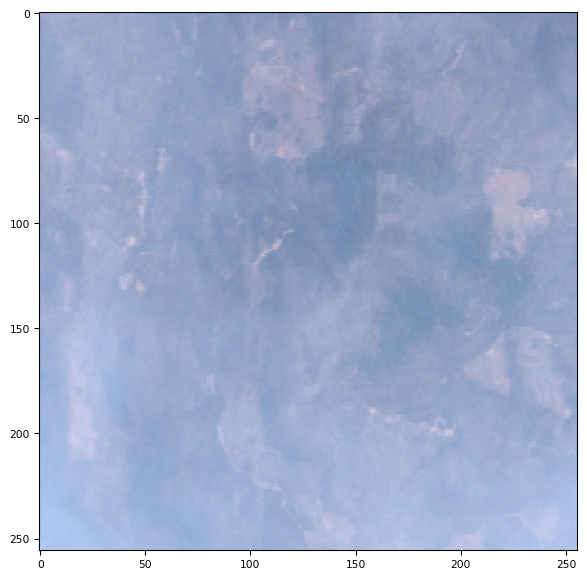

In [15]:
# Open the GeoTIFF file
file_path = 'rotated_RGB_AfterFire1_tile_111.tif'
rgb_image = tifffile.imread(file_path)

# Visualize the RGB image
tifffile.imshow(rgb_image)


### Augment the data with a 270 degree rotation to the right

In [3]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT270_afterRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_image(image_path, rotated_output_path, 3)


### Flip the images horizontally

In [6]:
def flip_image_horizontal(image_path, output_path):
    with rasterio.open(image_path) as src:
        # Read the image data and metadata
        img_array = src.read()
        metadata = src.meta

        # Flip the image array horizontally
        img_array = np.flip(img_array, axis=2)  # Flip along the width axis

        # Update metadata
        new_transform = from_origin(metadata['transform'][2], metadata['transform'][5], metadata['transform'][0], metadata['transform'][4])
        metadata.update(transform=new_transform)

        # Save the horizontally flipped image
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(img_array)

# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles'

# Specify the directory to save horizontally flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/HorFlip_afterRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Flip each RGB image horizontally and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_horizontal_{image_file}')
        flip_image_horizontal(image_path, flipped_output_path)


### Flip the images vertically

In [7]:
def flip_image_vertical(image_path, output_path):
    with rasterio.open(image_path) as src:
        # Read the image data and metadata
        img_array = src.read()
        metadata = src.meta

        # Flip the image array vertically
        img_array = np.flip(img_array, axis=1)  # Flip along the height axis

        # Update metadata
        new_transform = from_origin(metadata['transform'][2], metadata['transform'][5], metadata['transform'][0], metadata['transform'][4])
        metadata.update(transform=new_transform)

        # Save the vertically flipped image
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(img_array)

# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles'

# Specify the directory to save vertically flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/VertFlip_afterRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Flip each RGB image vertically and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_vertical_{image_file}')
        flip_image_vertical(image_path, flipped_output_path)

#### Let's visualize this

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fa530915ee0>)

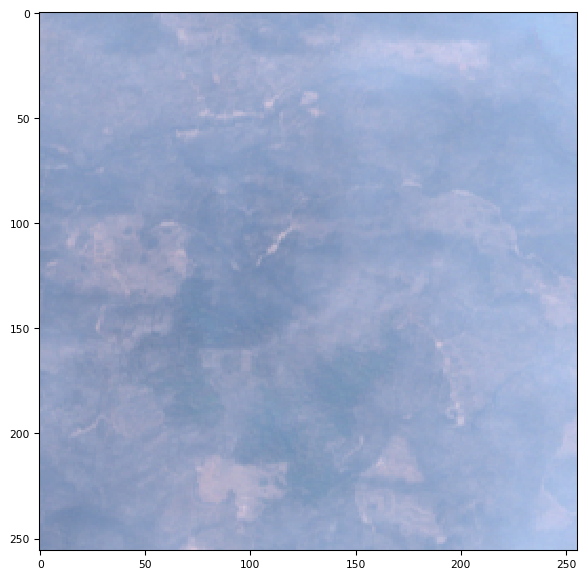

In [10]:
# Open the GeoTIFF file
file_path = 'flipped_horizontal_RGB_AfterFire1_tile_111.tif'
rgb_image = tifffile.imread(file_path)

# Visualize the RGB image
tifffile.imshow(rgb_image)


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fa537716580>)

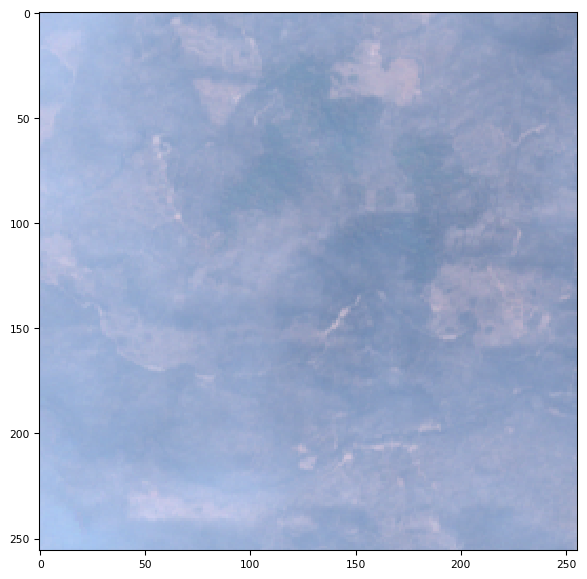

In [11]:
# Open the GeoTIFF file
file_path = 'flipped_vertical_RGB_AfterFire1_tile_111.tif'
rgb_image = tifffile.imread(file_path)

# Visualize the RGB image
tifffile.imshow(rgb_image)


### Now we will perform this augmentation techniques with the corresponding masks
#### Rotating function

In [27]:
def rotate_single_channel_image(image_path, output_path, n):
    with rasterio.open(image_path) as src:
        # Read the image data and metadata
        img_array = src.read()
        metadata = src.meta

        # Rotate the single-channel image array by 90 degrees to the right
        rotated_img_array = np.rot90(img_array, k=n, axes=(1, 2))  # Rotate along the height and width axes

        # Update metadata with the rotated transform
        new_transform = from_origin(metadata['transform'][2], metadata['transform'][5], metadata['transform'][0], metadata['transform'][4])

        metadata.update(transform=new_transform)

        # Save the rotated image
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(rotated_img_array)

#### 90 degree mask rotation

In [28]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/MaskDamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT90_afterMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_single_channel_image(image_path, rotated_output_path, 1)

/opt/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


#### 180 degree mask rotation

In [29]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/MaskDamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT180_afterMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_single_channel_image(image_path, rotated_output_path, 2)

#### 270 degree mask rotation

In [30]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/MaskDamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT270_afterMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_single_channel_image(image_path, rotated_output_path, 3)

#### Horizontal flip

In [32]:
# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/MaskDamageTiles'

# Specify the directory to save horizontally flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/HorFlip_afterMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Flip each RGB image horizontally and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_horizontal_{image_file}')
        flip_image_horizontal(image_path, flipped_output_path)


#### Vertical flip

In [33]:
# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/MaskDamageTiles'

# Specify the directory to save horizontally flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/VertFlip_afterMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)
# Flip each RGB image vertically and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_vertical_{image_file}')
        flip_image_vertical(image_path, flipped_output_path)

## Before Images augmentation
### Before images pairing with the damaged tiles

In [26]:
# Define the paths to the image folders
before_folder = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGBSegments'
after_folder = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/RGB_DamageTiles'
output_folder = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGB_DamageTiles'

# Get the list of files in each folder
before_files = os.listdir(before_folder)
after_files = os.listdir(after_folder)

# Regular expression pattern to extract X and Y values from the file name
pattern = re.compile(r'RGB_BeforeFire(\d+)_tile_(\d+)\.tif')

# Iterate through the 'before' files and find matching 'after' files
for before_file in before_files:
    match = pattern.match(before_file)
    if match:
        # Extract X and Y from the 'before' file name
        x_before, y_before = map(int, match.groups())

        # Find the corresponding 'after' file
        after_file = f'RGB_AfterFire{x_before}_tile_{y_before}.tif'

        # Check if the 'after' file exists
        if after_file in after_files:
            # Construct the full paths for copying
            before_path = os.path.join(before_folder, before_file)
            after_path = os.path.join(after_folder, after_file)
            output_path = os.path.join(output_folder, before_file)

            # Copy the 'before' file to the output folder
            shutil.copyfile(before_path, output_path)

            print(f'Paired: {before_file} and {after_file}')

print('Task completed.')

Paired: RGB_BeforeFire713_tile_105.tif and RGB_AfterFire713_tile_105.tif
Paired: RGB_BeforeFire712_tile_25.tif and RGB_AfterFire712_tile_25.tif
Paired: RGB_BeforeFire712_tile_26.tif and RGB_AfterFire712_tile_26.tif
Paired: RGB_BeforeFire712_tile_42.tif and RGB_AfterFire712_tile_42.tif
Paired: RGB_BeforeFire712_tile_43.tif and RGB_AfterFire712_tile_43.tif
Paired: RGB_BeforeFire712_tile_44.tif and RGB_AfterFire712_tile_44.tif
Paired: RGB_BeforeFire712_tile_45.tif and RGB_AfterFire712_tile_45.tif
Paired: RGB_BeforeFire712_tile_59.tif and RGB_AfterFire712_tile_59.tif
Paired: RGB_BeforeFire712_tile_60.tif and RGB_AfterFire712_tile_60.tif
Paired: RGB_BeforeFire712_tile_61.tif and RGB_AfterFire712_tile_61.tif
Paired: RGB_BeforeFire712_tile_62.tif and RGB_AfterFire712_tile_62.tif
Paired: RGB_BeforeFire712_tile_76.tif and RGB_AfterFire712_tile_76.tif
Paired: RGB_BeforeFire712_tile_77.tif and RGB_AfterFire712_tile_77.tif
Paired: RGB_BeforeFire712_tile_78.tif and RGB_AfterFire712_tile_78.tif
Pair

### Before Mask Pairing 

In [31]:
# Define the paths to the image folders
before_damage_tiles_folder = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGB_DamageTiles'
before_mask_segments_folder = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeMaskSegments'
output_folder = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeMask_DamageTiles'

# Get the list of files in each folder
damage_tiles_files = os.listdir(before_damage_tiles_folder)
mask_segments_files = os.listdir(before_mask_segments_folder)

# Regular expression pattern to extract X and Y values from the file name
pattern = re.compile(r'RGB_BeforeFire(\d+)_tile_(\d+)\.tif')

# Iterate through the 'BeforeRGB_DamageTiles' files and find matching 'BeforeMaskSegments' files
for damage_tiles_file in damage_tiles_files:
    match = pattern.match(damage_tiles_file)
    if match:
        # Extract X and Y from the 'BeforeRGB_DamageTiles' file name
        x_damage_tiles, y_damage_tiles = map(int, match.groups())

        # Find the corresponding 'BeforeMaskSegments' file
        mask_segments_file = f'RGB_BeforeFire{x_damage_tiles}_with_mask_tile_{y_damage_tiles}.tif'

        # Check if the 'BeforeMaskSegments' file exists
        if mask_segments_file in mask_segments_files:
            # Construct the full paths for copying
            damage_tiles_path = os.path.join(before_damage_tiles_folder, damage_tiles_file)
            mask_segments_path = os.path.join(before_mask_segments_folder, mask_segments_file)
            output_path = os.path.join(output_folder, mask_segments_file)

            # Copy the 'BeforeMaskSegments' file to the output folder
            shutil.copyfile(mask_segments_path, output_path)

            print(f'Paired: {damage_tiles_file} and {mask_segments_file}')

print('Task completed.')

Paired: RGB_BeforeFire713_tile_105.tif and RGB_BeforeFire713_with_mask_tile_105.tif
Paired: RGB_BeforeFire712_tile_25.tif and RGB_BeforeFire712_with_mask_tile_25.tif
Paired: RGB_BeforeFire712_tile_26.tif and RGB_BeforeFire712_with_mask_tile_26.tif
Paired: RGB_BeforeFire712_tile_42.tif and RGB_BeforeFire712_with_mask_tile_42.tif
Paired: RGB_BeforeFire712_tile_43.tif and RGB_BeforeFire712_with_mask_tile_43.tif
Paired: RGB_BeforeFire712_tile_44.tif and RGB_BeforeFire712_with_mask_tile_44.tif
Paired: RGB_BeforeFire712_tile_45.tif and RGB_BeforeFire712_with_mask_tile_45.tif
Paired: RGB_BeforeFire712_tile_59.tif and RGB_BeforeFire712_with_mask_tile_59.tif
Paired: RGB_BeforeFire712_tile_60.tif and RGB_BeforeFire712_with_mask_tile_60.tif
Paired: RGB_BeforeFire712_tile_61.tif and RGB_BeforeFire712_with_mask_tile_61.tif
Paired: RGB_BeforeFire712_tile_62.tif and RGB_BeforeFire712_with_mask_tile_62.tif
Paired: RGB_BeforeFire712_tile_76.tif and RGB_BeforeFire712_with_mask_tile_76.tif
Paired: RGB_Be

### RGB 90 degree rotation

In [34]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGB_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT90_beforeRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_image(image_path, rotated_output_path, 1)


### RGB 180 degree rotation

In [35]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGB_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT180_beforeRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_image(image_path, rotated_output_path, 2)


### RGB 270 degree rotation

In [36]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGB_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT270_beforeRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_image(image_path, rotated_output_path, 3)


### RGB Horizontal flip

In [37]:
# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGB_DamageTiles'

# Specify the directory to save horizontally flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/HorFlip_beforeRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Flip each RGB image horizontally and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_horizontal_{image_file}')
        flip_image_horizontal(image_path, flipped_output_path)


### RGB Vertical flip

In [38]:
# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeRGB_DamageTiles'

# Specify the directory to save vertically flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/VertFlip_beforeRGBdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Flip each RGB image vertically and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_vertical_{image_file}')
        flip_image_vertical(image_path, flipped_output_path)

### MASK 90 degree rotation

In [39]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeMask_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT90_beforeMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_single_channel_image(image_path, rotated_output_path, 1)

### MASK 180 degree rotation

In [40]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeMask_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT180_beforeMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_single_channel_image(image_path, rotated_output_path, 2)

### MASK 270 degree rotation

In [41]:
# Specify the directory containing the original images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeMask_DamageTiles'

# Specify the directory to save rotated images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/ROT270_beforeMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Rotate each image and save the rotated images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        rotated_output_path = os.path.join(destination_directory, f'rotated_{image_file}')
        rotate_single_channel_image(image_path, rotated_output_path, 3)

### MASK Horizontal flip

In [42]:
# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeMask_DamageTiles'

# Specify the directory to save horizontally flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/HorFlip_beforeMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# Flip each RGB image horizontally and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_horizontal_{image_file}')
        flip_image_horizontal(image_path, flipped_output_path)


### MASK Vertical flip

In [43]:
# Specify the directory containing the original RGB images
source_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/BeforeMask_DamageTiles'

# Specify the directory to save horizontally flipped images
destination_directory = '/Volumes/HD710PRO/Fire_and_Hurricane_Images/Fire/VertFlip_beforeMaskdamage'

# Make sure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)
# Flip each RGB image vertically and save the flipped images
for image_file in os.listdir(source_directory):
    if image_file.lower().endswith('.tif'):
        image_path = os.path.join(source_directory, image_file)
        flipped_output_path = os.path.join(destination_directory, f'flipped_vertical_{image_file}')
        flip_image_vertical(image_path, flipped_output_path)